In [309]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sktime.utils.plotting import plot_series
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.stats.diagnostic import acorr_ljungbox

In [ ]:
us_change = pd.read_csv("data/us_change.csv")

,Quarter,Consumption,Income,Production,Savings,Unemployment
0,1970 Q1,0.618566,1.044801,-2.452486,5.299014,0.9
1,1970 Q2,0.451984,1.225647,-0.551459,7.789894,0.5
2,1970 Q3,0.872872,1.585154,-0.358652,7.403984,0.5
3,1970 Q4,-0.271848,-0.239545,-2.185691,1.169898,0.7
4,1971 Q1,1.901345,1.975925,1.909764,3.535667,-0.1


In [242]:
class Conv1dModel(nn.Module):
    def __init__(self, channels, prediction_horizon, kernel=3, depth=2):
        super().__init__()
        
        self.channels = channels
        self.prediction_horizon = prediction_horizon
        
        self.layers = nn.Sequential()
        
        in_channels = channels
        padding = (kernel - 1) // 2
        for _ in range(depth):
            out_channels = 2 * in_channels
            self.layers.append(nn.Conv1d(
                in_channels,
                out_channels,
                kernel_size=kernel,
                padding=padding
            ))
            in_channels = out_channels
            self.layers.append(nn.ReLU())
        
        self.layers.append(nn.MaxPool1d(2))
        self.layers.append(nn.Flatten())
        
        self.layers.append(nn.Dropout(0.2))
        self.layers.append(nn.LazyLinear(32))
        self.layers.append(nn.ReLU())
        
        self.layers.append(nn.Dropout(0.2))
        self.layers.append(nn.Linear(32, 16))
        self.layers.append(nn.ReLU())
        
        self.layers.append(nn.Linear(16, prediction_horizon))
    
    def forward(self, x):
        return self.layers(x)

In [243]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [286]:
def train(model, device, train_loader, optimizer):
    model.train()
    hist_loss = 0
    for data_seq, target in train_loader:
        data_seq, target = data_seq.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data_seq)
        loss = nn.functional.mse_loss(output, target)
        loss.backward()
        optimizer.step()
        hist_loss += loss.item()
        
    hist_loss /= len(train_loader.dataset)
    return hist_loss

In [245]:
def evaluate(model, device, val_loader):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for data_seq, target_val in val_loader:
            data_seq, target_val = data_seq.to(device), target_val.to(device)
            output = model(data_seq)
            val_loss += nn.functional.mse_loss(output, target_val).item()

    val_loss /= len(val_loader.dataset)
    return val_loss

In [246]:
def generate_sequences(data, target, sequence_length, prediction_horizon):
    data_values = data.to_numpy().T
    target_idx = data.columns.get_loc(target)
    
    means = data_values.mean(axis=1, keepdims=True)
    stds = data_values.std(axis=1, keepdims=True)
    
    data_len = len(data)
    effective_len = data_len - sequence_length - prediction_horizon
    data_sequences = []
    for i in range(effective_len):
        sequence = torch.tensor((data_values[:,i:i+sequence_length] - means) / stds, dtype=torch.float32)
        target_value = torch.tensor(data_values[target_idx,i+sequence_length:i+sequence_length+prediction_horizon], dtype=torch.float32)
        data_sequences.append((sequence, target_value))
    
    return data_sequences

In [ ]:
def kfold_val_loss(data, k, params_list, sequence_length, prediction_horizon, device, target, random_state=42):
    default_params = {
        "channels": 5,
        "kernel": 3,
        "depth": 2
    }
    
    data_sequences = generate_sequences(data, target, sequence_length, prediction_horizon)
    
    kfold = KFold(k, shuffle=True, random_state=random_state)
    splits = list(kfold.split(data_sequences))
    val_losses = []
    
    for params in params_list:
        param_dict = default_params.copy()
        param_dict.update(params)
        param_dict["prediction_horizon"] = prediction_horizon
        val_loss = 0
        
        for train_idx, val_idx in splits:
            train_loader = DataLoader(
                dataset=data_sequences,
                batch_size=32,
                sampler=torch.utils.data.SubsetRandomSampler(train_idx),
            )
            val_loader = DataLoader(
                dataset=data_sequences,
                batch_size=32,
                sampler=torch.utils.data.SubsetRandomSampler(val_idx),
            )
            
            model = Conv1dModel(**param_dict).to(device)
            optimizer = torch.optim.Adam(model.parameters())
            
            for _ in range(100):
                train(model, device, train_loader, optimizer)
            
            val_loss += evaluate(model, device, val_loader)
        val_losses.append(val_loss / k)
    return val_losses

In [248]:
data = us_change[["Consumption", "Income", "Production", "Savings", "Unemployment"]]
data_train = data[:-8]

data_train_values = data_train.to_numpy().T

means_train = data_train_values.mean(axis=1, keepdims=True)
stds_train = data_train_values.std(axis=1, keepdims=True)

In [311]:
params_list = [
    {"kernel": 3, "depth": 2},
    {"kernel": 5, "depth": 2},
    {"kernel": 7, "depth": 2},
    {"kernel": 3, "depth": 3},
    {"kernel": 5, "depth": 3},
    {"kernel": 7, "depth": 3},
    {"kernel": 3, "depth": 4},
    {"kernel": 5, "depth": 4},
    {"kernel": 7, "depth": 4}
]

min_loss = float('inf')
best_model = None
best_seq_length = None

for sequence_length in [4, 8, 12, 16]:  
    losses = kfold_val_loss(
        data_train,
        5,
        params_list,
        sequence_length,
        8,
        device,
        "Consumption"
    )
    
    for i, loss in enumerate(losses):
        if loss < min_loss:
            min_loss = loss
            best_model = params_list[i]
            best_seq_length = sequence_length

In [312]:
print(best_model)
print(best_seq_length)
print(min_loss)

{'kernel': 5, 'depth': 4}
16
0.0019346696582723815


In [364]:
model = Conv1dModel(5, 8, **best_model).to(device)
optimizer = torch.optim.Adam(model.parameters())

data_sequences = generate_sequences(data_train, "Consumption", best_seq_length, 8)
train_loader = DataLoader(
    dataset=data_sequences,
    batch_size=32
)

history = []
model.train()
for _ in range(100):
    train_loss = train(model, device, train_loader, optimizer)
    history.append(train_loss)

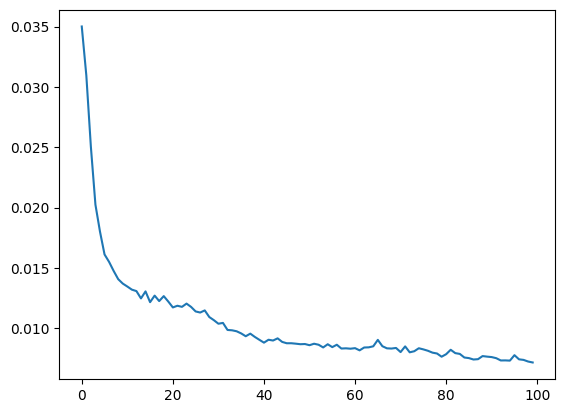

In [365]:
plt.plot(history)
plt.show()

In [366]:
test_data = (data[-best_seq_length-8:-8].to_numpy().T - means_train) / stds_train
test_data = torch.tensor(test_data, dtype=torch.float32).to(device)
test_data = torch.unsqueeze(test_data, 0)

model.eval()
with torch.no_grad():
    predictions_test = model(test_data)

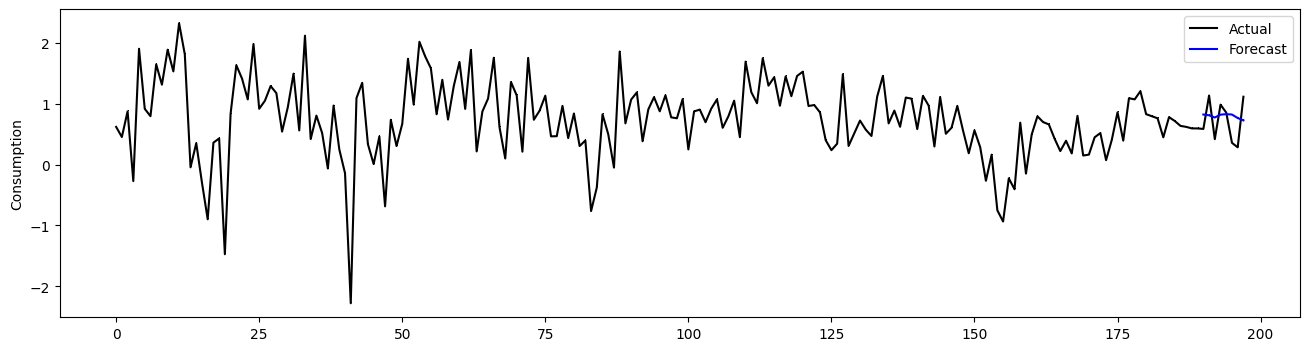

In [367]:
pred_series_test = pd.Series(predictions_test.cpu()[0])
pred_series_test.index = pred_series_test.index + 190
plot_series(
    us_change["Consumption"], pred_series_test,
    labels=["Actual", "Forecast"],
    colors = ["black", "blue"],
    markers=[",", ","]
)
plt.legend()
plt.show()

In [368]:
data_sequences = generate_sequences(data, "Consumption", best_seq_length, 1)

model.eval()
residuals = []
predictions = []
with torch.no_grad():
    for data_seq, tgt in data_sequences:
        dat_seq_unsq = torch.unsqueeze(data_seq, 0).to(device)
        pred = model(dat_seq_unsq).cpu()
        res = tgt[0] - pred[0][0]
        residuals.append(res.item())
        predictions.append(pred[0][0].item())

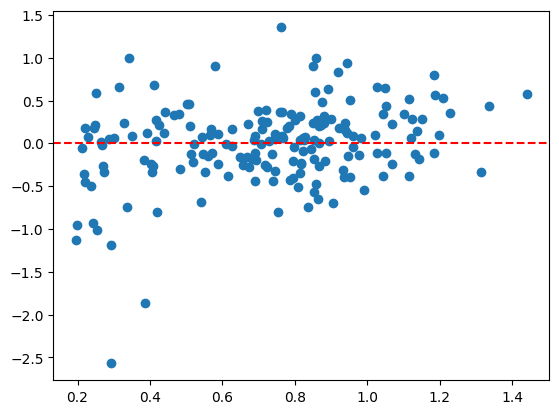

In [369]:
plt.scatter(predictions, residuals)
plt.axhline(0, color="red", linestyle="--")
plt.show()

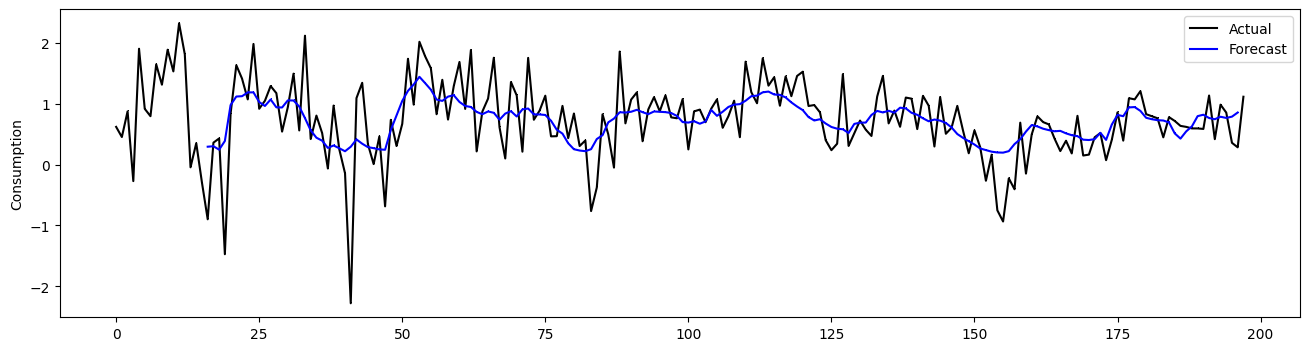

In [370]:
pred_series = pd.Series(predictions)
pred_series.index = pred_series.index + best_seq_length
plot_series(
    us_change["Consumption"], pred_series,
    labels=["Actual", "Forecast"],
    colors = ["black", "blue"],
    markers=[",", ","]
)
plt.legend()
plt.show()

In [371]:
# Teste de Ljung-Box
ljung_box_results = acorr_ljungbox(residuals, lags=[10], return_df=True)
print(ljung_box_results)

     lb_stat  lb_pvalue
10  7.803205   0.648053


# Métricas

In [372]:
real_data = us_change["Consumption"][pred_series.index[0]:pred_series.index[-1]+1]

# MAE
mae = mean_absolute_error(real_data, pred_series)

# MSE
mse = mean_squared_error(real_data, pred_series)

# RMSE
rmse = np.sqrt(mse)

#MAPE
mape = np.mean(np.abs((real_data - pred_series) / real_data)) * 100

# R²
r2 = r2_score(real_data, pred_series)

print(f"MAE: {mae}", f"MSE: {mse}", f"RMSE: {rmse}", 
      f"MAPE: {mape}%", f"R²: {r2}",
      sep="\n")

MAE: 0.34015187921537204
MSE: 0.2260410236577838
RMSE: 0.4754377179587078
MAPE: 89.64864051208886%
R²: 0.40572057925960103


In [373]:
real_values = us_change["Consumption"][-8:]

# Avaliação das previsões fora da amostra
mae_outsample = mean_absolute_error(real_values, pred_series_test)
mse_outsample = mean_squared_error(real_values, pred_series_test)
print(f"Out-of-sample MAE: {mae_outsample}, MSE: {mse_outsample}")

Out-of-sample MAE: 0.3048959865251648, MSE: 0.1140644260675793
